## Distibuted Training With Hyperparameter tuning and Generic Model Flavors

In [1]:
import numpy as np
import tensorflow as tf
import mlflow
import time
import json
from sys import version_info
from mlflow.models import infer_signature
print("TF Version :", tf.__version__)

TF Version : 2.19.0


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ds_with_mlflow_flavor").master("spark://spark-master:7077") \
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/04 03:54:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/04 03:54:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/04 03:54:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/05/04 03:54:53 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [3]:
mlflow_uri = "http://mlflow-server:8888"
mlflow.set_tracking_uri(mlflow_uri)
time.sleep(5)
#mlflow.set_experiment(mlflow_uri)
mlflow.set_experiment("ds_with_mlflow_flavor")

2025/05/04 03:54:59 INFO mlflow.tracking.fluent: Experiment with name 'ds_with_mlflow_flavor' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/916513622869294750', creation_time=1746330899731, experiment_id='916513622869294750', last_update_time=1746330899731, lifecycle_stage='active', name='ds_with_mlflow_flavor', tags={}>

In [4]:
# load dataset
mnist = tf.keras.datasets.mnist

(x_train, y_train) , (x_test,y_test) = mnist.load_data()
x_train,x_test =  x_train/255.0 , x_test/255.0

print(x_train.shape)
print(y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(60000, 28, 28)
(60000,)


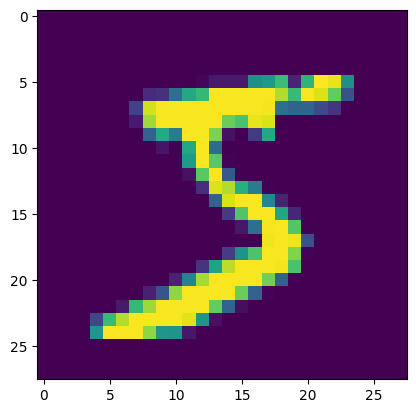

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [7]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt import SparkTrials, Trials

spark_trails = Trials()

In [8]:
from sys import version_info
conda_env_tf = {
    "channels": ["defaults"],
    "dependencies": [
        f"python={version_info.major}.{version_info.minor}.{version_info.micro}",
        "pip",
        {"pip": ["mlflow",
                 f"tensorflow=={tf.__version__}"]
        },
    ],
    "name": "tf_env"
}
conda_env_tf

{'channels': ['defaults'],
 'dependencies': ['python=3.12.10',
  'pip',
  {'pip': ['mlflow', 'tensorflow==2.19.0']}],
 'name': 'tf_env'}

In [9]:
import json
class custom_tf_model(mlflow.pyfunc.PythonModel):
    def __init__(self,params):
        self.params = params
        self.tf_model = None
        self.config = None

    def load_context(self, context = None, config_path = None):
        if context:
            config_path = context.artifacts["config_path"]
            
        else:
            pass
        self.config = json.load(open(config_path))

    
    def fit(self,x_train,y_train):

        tf_model = self.create_model(p_optimizer=self.config["optimizer"],
                                     l1_noNode=self.config["l1_noNode"],
                                     l1_activation = self.config["l1_activation"],
                                     l1_dropout = self.config["l1_dropout"])

        tf_model.fit(x_train,y_train,epochs = self.params["epochs"])
        self.tf_model = tf_model


    def predict(self,context, model_input):
        return self.tf_model.predict(model_input)
    
    def evaluate(self,context,test_x,test_y):
        eval_loss, eval_acc = self.tf_model.evaluate(x_test,y_test,verbose=2)
        return eval_loss, eval_acc


    def create_model(self,p_optimizer = "Adam", l1_noNode= 32, l1_activation="relu",l1_dropout= 0.2):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(l1_noNode,activation=l1_activation),
            tf.keras.layers.Dropout(l1_dropout),
            tf.keras.layers.Dense(10)
        ])

        loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer = p_optimizer,loss= loss_func, metrics = ['accuracy'])

        return model
    





/usr/local/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [10]:
def train_with_hyperopt(params):
    with mlflow.start_run(nested=True) as run1 :
        p_epoch = params["epochs"]
        p_optimizer = params["optimizer"]
        l1_noNode = params["l1_noNode"]
        l1_activation = params["l1_activation"]
        l1_dropout  = params["l1_dropout"]


        mlflow.log_params(params)

        # create the configfile
        config_path = "data_tf.json"
        artifacts_tf = {"config_path" : config_path}   
        with open(config_path,"w") as f:
            json.dump(params,f)
        
        # create generic model
        params_ = {"epochs" : 5}
        config_path = "data_tf.json"
        custom_tf_model_obj = custom_tf_model(params_)
        custom_tf_model_obj.load_context(config_path=config_path)
        custom_tf_model_obj.fit(x_train=x_train,y_train=y_train)

        # Calculate LOSS and Acc
        eval_loss, eval_acc = custom_tf_model_obj.evaluate(context=None,
                                                           test_x=x_test,
                                                           test_y=y_test)

     
        mlflow.log_metric("eval_loss",eval_loss)
        mlflow.log_metric("eval_acc",eval_acc)


        # Prepare to generic model
        predictions_tf = custom_tf_model_obj.predict(context=None,model_input=x_test)
        model_signature = infer_signature(x_test,predictions_tf)
        mlflow.pyfunc.log_model(
            "custom_tf",
            python_model = custom_tf_model_obj,
            artifacts = artifacts_tf,
            conda_env = conda_env_tf,
            signature = model_signature,
            input_example = x_train[0]
        )


    return {"loss" : eval_loss, "status" : STATUS_OK, "model" : custom_tf_model_obj, "eval_acc":eval_acc}
        

In [13]:
epochs = [2,4,6,8]
optimizer = ["Adam","SGD","RMSprop"]
l1_noNode = [32,64,128]
l1_activation = ["relu","tanh","softmax"]
l1_dropout = [0.2,0.3,0.6]


search_params_space = {
    "epochs" : hp.choice("epochs",epochs),
    "optimizer" : hp.choice("optimizer",optimizer),
    "l1_noNode" : hp.choice("l1_noNode",l1_noNode),
    "l1_activation" : hp.choice("l1_activation",l1_activation),
    "l1_dropout" : hp.choice("l1_dropout",l1_dropout)
}

algo = tpe.suggest


In [15]:
algo

<function hyperopt.tpe.suggest(new_ids, domain, trials, seed, prior_weight=1.0, n_startup_jobs=20, n_EI_candidates=24, gamma=0.25, verbose=True)>

In [16]:
with mlflow.start_run() as run :
   args_min = fmin(
      fn=train_with_hyperopt,
      space=search_params_space,
      algo = algo,
      max_evals=3,
      trials=spark_trails
   )

2025/05/04 04:00:20 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



  0%|          | 0/3 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/5                                            

  0%|          | 0/3 [00:01<?, ?trial/s, best loss=?]

2025-05-04 04:00:21.885244: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


   1/1875 ━━━━━━━━━━━━━━━━━━━━ 8:24 269ms/step - accuracy: 0.0625 - loss: 2.3041
  28/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1378 - loss: 2.2990    
  56/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1682 - loss: 2.2948
  83/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1867 - loss: 2.2906
 122/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2132 - loss: 2.2836
 167/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2382 - loss: 2.2731
 195/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2506 - loss: 2.2657
 232/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2636 - loss: 2.2557
 262/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2722 - loss: 2.2475
 302/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2816 - loss: 2.2369
 345/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2897 - loss: 2.2260
 390/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2967 - loss: 2.2150
 441/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3030 - loss

2025-05-04 04:00:33.926157: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


313/313 - 0s - 843us/step - accuracy: 0.9137 - loss: 0.5644

  1/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
110/313 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
232/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step

  0%|          | 0/3 [00:13<?, ?trial/s, best loss=?]

2025-05-04 04:00:34.269897: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2025/05/04 04:00:34 INFO mlflow.pyfunc: Validating input example against model signature



🏃 View run tasteful-whale-955 at: http://mlflow-server:8888/#/experiments/916513622869294750/runs/933f4324f054497dbb3021b199dc408d

🧪 View experiment at: http://mlflow-server:8888/#/experiments/916513622869294750

  0%|          | 0/3 [00:13<?, ?trial/s, best loss=?]

ERROR:hyperopt.fmin:job exception: Input example does not match the model signature. Error: Failed to enforce schema of data '[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         

  0%|          | 0/3 [00:13<?, ?trial/s, best loss=?]
🏃 View run sedate-pug-870 at: http://mlflow-server:8888/#/experiments/916513622869294750/runs/bff0ad2762914474a9eacb7e0c403592
🧪 View experiment at: http://mlflow-server:8888/#/experiments/916513622869294750


MlflowException: Input example does not match the model signature. Error: Failed to enforce schema of data '[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.01176471 0.07058824 0.07058824 0.07058824 0.49411765 0.53333333
  0.68627451 0.10196078 0.65098039 1.         0.96862745 0.49803922
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.11764706 0.14117647 0.36862745 0.60392157
  0.66666667 0.99215686 0.99215686 0.99215686 0.99215686 0.99215686
  0.88235294 0.6745098  0.99215686 0.94901961 0.76470588 0.25098039
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.19215686 0.93333333 0.99215686 0.99215686 0.99215686
  0.99215686 0.99215686 0.99215686 0.99215686 0.99215686 0.98431373
  0.36470588 0.32156863 0.32156863 0.21960784 0.15294118 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.07058824 0.85882353 0.99215686 0.99215686 0.99215686
  0.99215686 0.99215686 0.77647059 0.71372549 0.96862745 0.94509804
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.31372549 0.61176471 0.41960784 0.99215686
  0.99215686 0.80392157 0.04313725 0.         0.16862745 0.60392157
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.05490196 0.00392157 0.60392157
  0.99215686 0.35294118 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.54509804
  0.99215686 0.74509804 0.00784314 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.04313725
  0.74509804 0.99215686 0.2745098  0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.1372549  0.94509804 0.88235294 0.62745098 0.42352941 0.00392157
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.31764706 0.94117647 0.99215686 0.99215686 0.46666667
  0.09803922 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.17647059 0.72941176 0.99215686 0.99215686
  0.58823529 0.10588235 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.0627451  0.36470588 0.98823529
  0.99215686 0.73333333 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.97647059
  0.99215686 0.97647059 0.25098039 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.18039216 0.50980392 0.71764706 0.99215686
  0.99215686 0.81176471 0.00784314 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.15294118 0.58039216 0.89803922 0.99215686 0.99215686 0.99215686
  0.98039216 0.71372549 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.09411765 0.44705882
  0.86666667 0.99215686 0.99215686 0.99215686 0.99215686 0.78823529
  0.30588235 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.09019608 0.25882353 0.83529412 0.99215686
  0.99215686 0.99215686 0.99215686 0.77647059 0.31764706 0.00784314
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.07058824 0.67058824 0.85882353 0.99215686 0.99215686 0.99215686
  0.99215686 0.76470588 0.31372549 0.03529412 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.21568627 0.6745098
  0.88627451 0.99215686 0.99215686 0.99215686 0.99215686 0.95686275
  0.52156863 0.04313725 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.53333333 0.99215686
  0.99215686 0.99215686 0.83137255 0.52941176 0.51764706 0.0627451
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]' with schema '[Tensor('float64', (-1, 28, 28))]'. Error: Shape of input (28, 28) does not match expected shape (-1, 28, 28).

In [52]:
### Generic model flavours

In [11]:
import mlflow
logged_model = 'runs:/330340b36fe24a9081a9d910f5c6f766/custom_tf'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
# Predict on a Pandas DataFrame.
import pandas as pd
result = loaded_model.predict(x_test[:10])
result